In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import division

%matplotlib inline

# Homework 4

$g(x|\theta) = w N(x | \mu_1, \sigma^2) + (1-w) N(x|\mu_2, \sigma^2)$

$\lambda=1/\sigma^2$ as GA(1,1)

$f(\mu_1)=N(0,100)$ and $f(\mu_2) = N(0,100)$

$f(w) = U(0,1)$

## 1.

In [36]:
sample1 = np.random.randn(100)  #100 samples from standard normal distribution


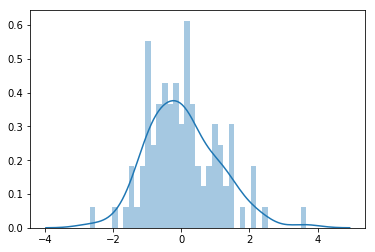

In [37]:
sns.distplot(sample1, bins=np.linspace(-4,4,50))
plt.show()

In [38]:
def gaussian(x, mu, lmbda):
    """
    compute probablity of Gaussian distribution with mean and inverse variance
    """
    return np.exp(-np.power(x - mu, 2.) * lmbda / 2 ) / np.sqrt(2*np.pi/lmbda)

In [39]:
def draw_d(w, mu1, mu2, lmbda, x):
    """
    :type w: float
    :type x: np.array
    :type mu1: float
    :type mu2: float
    :type lmbda: float
    :rtype: np.array
    """
    d = np.ones(len(x))
    u = np.random.uniform(0,1,len(x))
    p = w*(gaussian(x, mu1, lmbda))/(
        w*(gaussian(x, mu1, lmbda)) + (1-w)*(gaussian(x, mu2, lmbda)))
    d[u>p] == 2
    return d

def draw_w(d):
    n1 = (d==1).sum()
    return np.random.beta(n1+1, len(d)-n1+1)

def draw_lambda(mu1, mu2, d, a0, b0, x):#a0,b0 are the coefficient from Gamma prior
    a = len(x)/2 + a0
    b = b0+0.5*(np.power(x[d==1]-mu1, 2).sum() + np.power(x[d==2]-mu2, 2).sum())
    return np.random.gamma(a, 1/b)

def draw_mu1(d, lmbda, lmbda0, x):
    return np.random.normal(lmbda*x[d==1].sum()/(lmbda0+len(x[d==1])*lmbda), 1/np.sqrt(lmbda0+len(x[d==1])*lmbda))

def draw_mu2(d, lmbda, lmbda0, x):
    return np.random.normal(lmbda*x[d==2].sum()/(lmbda0+len(x[d==2])*lmbda), 1/np.sqrt(lmbda0+len(x[d==2])*lmbda))

In [64]:
N = 100000
w = np.random.uniform()
a0 = 1
b0 = 1
lmbda0 = 1/100
lmbda = np.random.gamma(a0, 1/b0)
mu1 = np.random.normal(0, 10)
mu2 = np.random.normal(0, 10)
parameters = np.zeros((N, 5))
sample5 = np.zeros(N)
for i in range(N):
    d = draw_d(w, mu1, mu2, lmbda, sample1)
    w = draw_w(d)
    lmbda = draw_lambda(mu1, mu2, d, a0, b0, sample1)
    mu1 = draw_mu1(d, lmbda, lmbda0, sample1)
    mu2 = draw_mu2(d, lmbda, lmbda0, sample1)
    parameters[i] = np.array([w, mu1, mu2, lmbda, d.mean()])
    u = np.random.uniform()
    if u < w:
        sample5[i] = np.random.normal(mu1, 1/np.sqrt(lmbda))
    else:
        sample5[i] = np.random.normal(mu2, 1/np.sqrt(lmbda))

In [65]:
x = np.linspace(-5, 5, 100)
distributions = np.zeros((N, len(x)))
for i in range(len(x)):
    distributions[i] = gaussian(x, parameters[i,1], parameters[i,3])*parameters[i, 0] + gaussian(
                                x, parameters[i,2], parameters[i,3])*(1-parameters[i, 0])


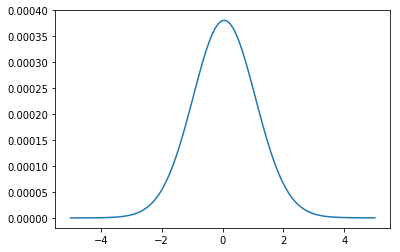

In [66]:
plt.plot(x, distributions.mean(axis = 0))

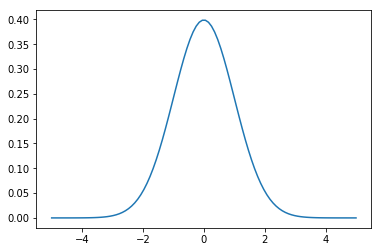

In [67]:
plt.plot(x, gaussian(x, 0, 1))

In [68]:
df = pd.DataFrame(parameters)
df.columns = ['w', 'mu_1', 'mu_2', 'lambda', 'd_mean']
df.head()

,w,mu_1,mu_2,lambda,d_mean
0,0.999548,-0.010448,-8.835252,0.242637,1.0
1,0.971918,-0.016075,1.440598,0.899356,1.0
2,0.985370,0.150955,-0.205943,0.919025,1.0
3,0.992639,0.242714,-6.797211,1.020307,1.0
4,0.999682,-0.134563,-5.517320,1.098927,1.0


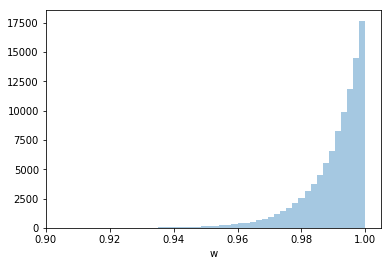

In [69]:
sns.distplot(df['w'], kde=False)

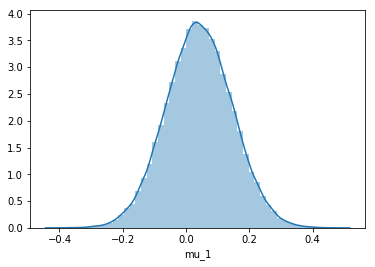

In [70]:
sns.distplot(df['mu_1'])

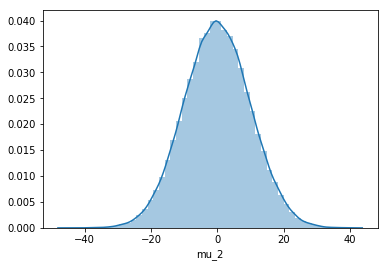

In [71]:
sns.distplot(df['mu_2'])

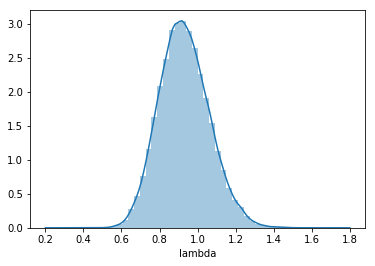

In [72]:
sns.distplot(df['lambda'])

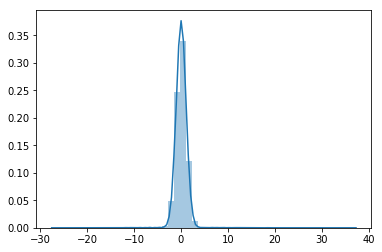

In [73]:
sns.distplot(sample5)

In [74]:
sample5.mean()

0.044402327433336171

In [75]:
(parameters[:,0]*parameters[:,1]+(1-parameters[:,0])*parameters[:,2]).mean()

0.040343443040938877

In [76]:
import gc
gc.collect()

65